In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import imageio
from smpl_torch import SMPLModel
from enum import Enum
import cv2

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# add path for demo utils functions 
import sys
import os
import copy
sys.path.append(os.path.abspath(''))


Bad key "text.kerning_factor" on line 4 in
/home/ax/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
class CocoPart(Enum):
    Nose = 0
    Neck = 1
    RShoulder = 2
    RElbow = 3
    RWrist = 4
    LShoulder = 5
    LElbow = 6
    LWrist = 7
    RHip = 8
    RKnee = 9
    RAnkle = 10
    LHip = 11
    LKnee = 12
    LAnkle = 13
    REye = 14
    LEye = 15
    REar = 16
    LEar = 17
    Background = 18

def get_body_image_from_mesh(cur_mesh, body_estimation, renderer):
    R, T = look_at_view_transform(2.0, 10, 0) 
    T[0, 1] = 0.3
    images = renderer(cur_mesh, R=R.cuda(), T=T.cuda())
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)

In [40]:
# Setup
ORIG_SHAPE = (512, 512, 3)
device = torch.device("cuda:0")
torch.cuda.set_device(device)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

pose_size = 72
beta_size = 10
fId = 10 # frame id of the mocap sequence
bdata = np.load('../data/AMASS/amass_sample.npz')
pose_np = (np.random.rand(pose_size) - 0.5) * 0.001
#pose_np = np.zeros(pose_size)
#pose_np[3:66] = bdata['poses'][fId:fId+1, 3:66] # DOES NOT WORK
pose_np[59] = 0.2
#pose_np[53] = 0.2

pose = torch.from_numpy(pose_np).type(torch.float64).to(device)
pose.requires_grad = True

betas_np = bdata['betas'][:beta_size]
# betas_np = np.zeros(beta_size)
betas = torch.from_numpy(betas_np).type(torch.float64).to(device)
betas.requires_grad = True
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

model = SMPLModel(device=device)
vertices = model(betas, pose, trans)

In [37]:
# add batch dim
verticies = vertices.unsqueeze(0).float()
faces = torch.from_numpy(model.faces.astype(np.long)).unsqueeze(0).cuda()

faces_uvs = faces.clone()
verts_uvs = torch.from_numpy(np.load('uv_table.npy')).float().unsqueeze(0).cuda()
maps = torch.from_numpy(
    cv2.cvtColor(cv2.imread("tex.png", cv2.IMREAD_COLOR),  cv2.COLOR_BGR2RGB) / 255
).unsqueeze(0).float().cuda()

textures = Textures(maps, faces_uvs, verts_uvs)

mesh = Meshes(verticies, faces, textures)

In [38]:
R, T = look_at_view_transform(2.0, 10, 0) 
T[0, 1] = 0.3
cameras = OpenGLPerspectiveCameras(device=device, R=R.cuda(), T=T.cuda())

raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

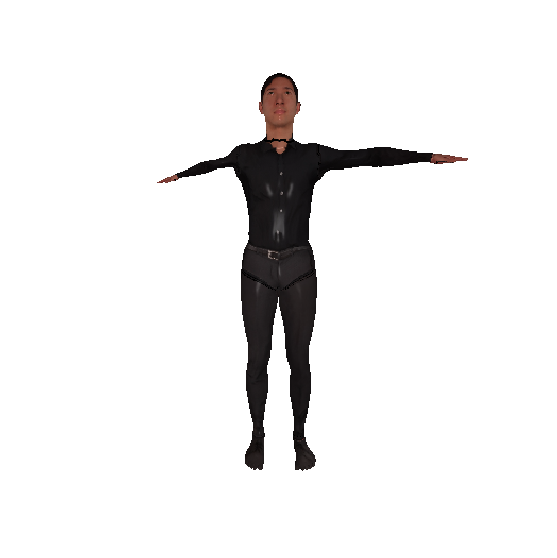

In [39]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off");
plt.axis("off");

0.0005691437399946153


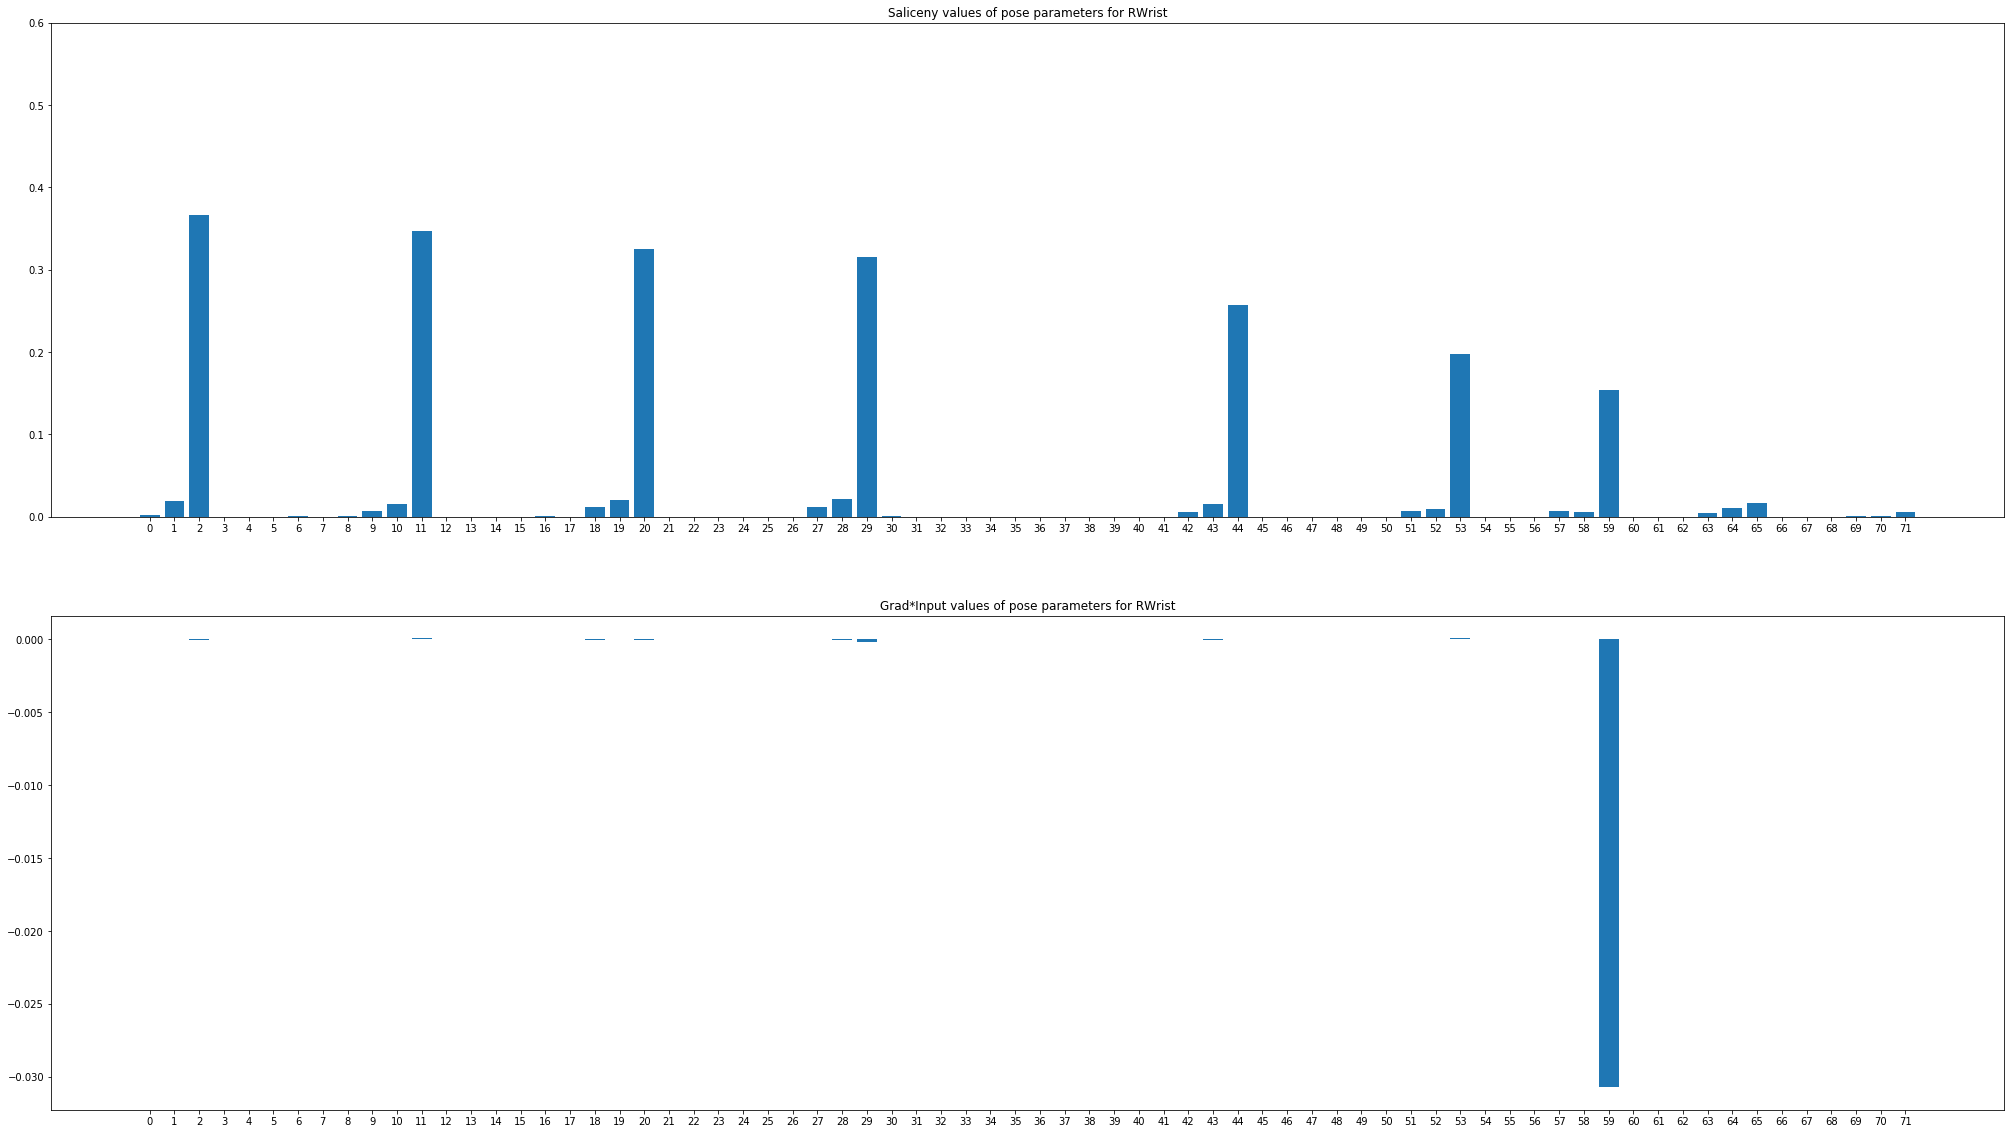

In [19]:
ATTRIBUTION_PART = CocoPart.RWrist
ATTRIBUTION_INDEX = ATTRIBUTION_PART.value # attribution index
ATTRIBUTION_NAME = ATTRIBUTION_PART.name # attribution index

body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
paf, heat = body_estimation.model(body_input)

heatmap_attr = heat[0, ATTRIBUTION_INDEX, :, :]
zero_heatmap = torch.zeros_like(heatmap_attr, device=device)
peak_tensor = where(heatmap_attr > 0.3, heatmap_attr, zero_heatmap)
loss = peak_tensor.mean()

print(loss.item())
loss.backward(retain_graph=True)
grad_pose_np = pose.grad.detach().cpu().numpy()
grad_beta_np = betas.grad.detach().cpu().numpy()

fig = plt.figure(figsize=(35, 20))
ax = fig.add_subplot(2, 1, 1)
x = range(grad_pose_np.shape[0])
ax.bar(x, np.abs(grad_pose_np))
plt.xticks(x)
ax.set_title(f"Saliceny values of pose parameters for {ATTRIBUTION_NAME}")
ax.set_ylim(0, 0.6)
# ax = fig.add_subplot(2, 2, 2)
# x = range(grad_beta_np.shape[0])
# ax.bar(x, np.abs(grad_beta_np))
# plt.xticks(x)
# ax.set_title(f"Saliceny of beta parameters for {ATTRIBUTION_NAME}")

ax = fig.add_subplot(2, 1, 2)
x = range(grad_pose_np.shape[0])
y = grad_pose_np * pose.detach().cpu().numpy()
ax.bar(x, y)
plt.xticks(x)
ax.set_title(f"Grad*Input values of pose parameters for {ATTRIBUTION_NAME}")

# ax = fig.add_subplot(2, 2, 4)
# x = range(grad_beta_np.shape[0])
# y = grad_beta_np * betas.detach().cpu().numpy()
# ax.bar(x, y)
# plt.xticks(x)
# ax.set_title(f"Grad*Input of beta parameters for {ATTRIBUTION_NAME}")
fig.savefig('../results/pytorch3d/smpl.png', dpi=100, bbox_inches='tight')

In [16]:
canvas_orig, *_ = get_body_image_from_mesh(mesh, body_estimation, renderer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SMPL with pose')

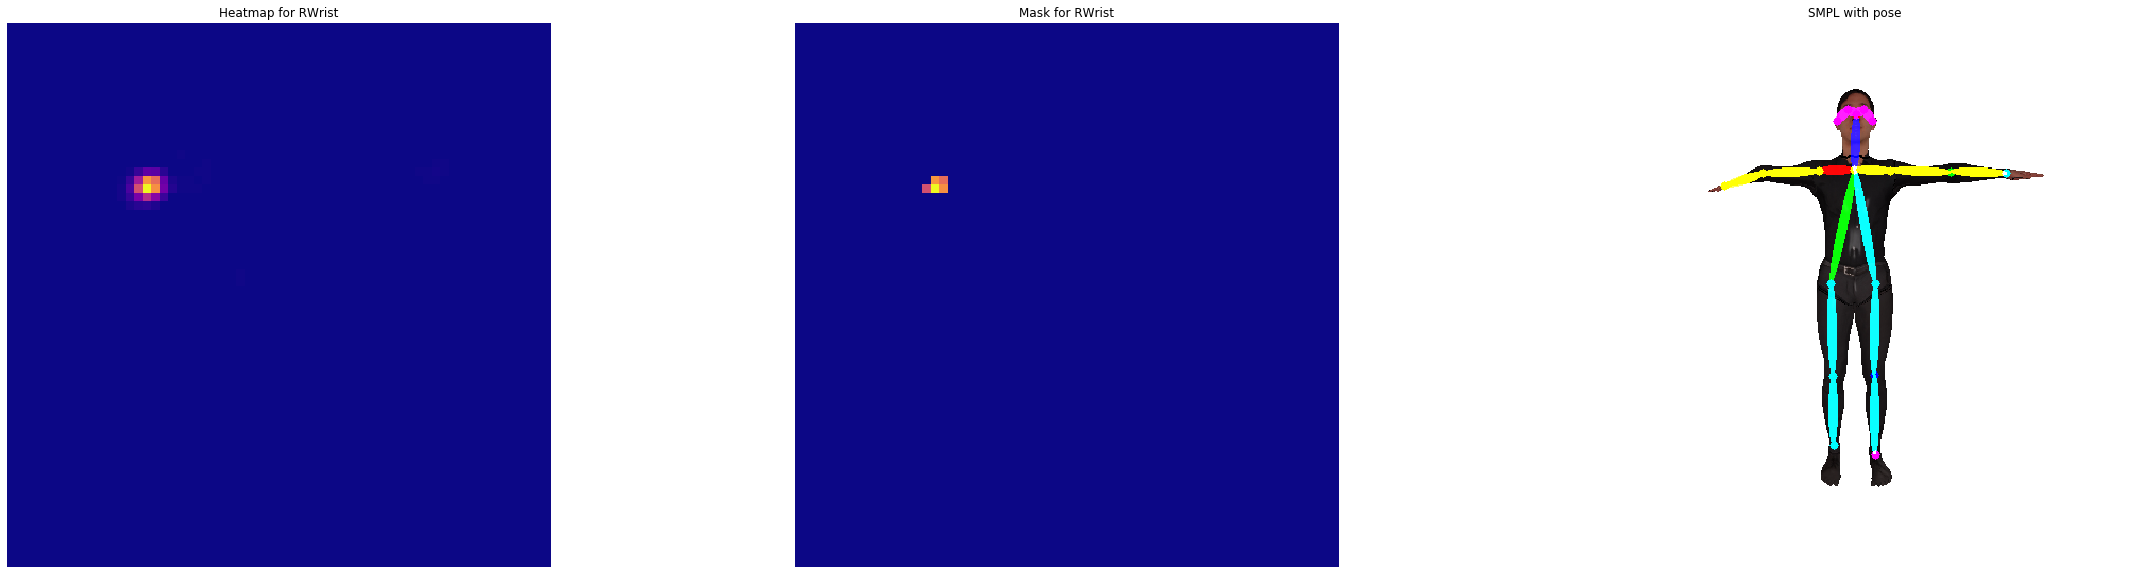

In [17]:

heatmap = heat[0, ATTRIBUTION_INDEX, :, :].detach().cpu().numpy()
peak_np = peak_tensor.detach().cpu().numpy()
fig = plt.figure(figsize=(40, 10))

ax = fig.add_subplot(1, 3, 1)
pcm = ax.imshow(heatmap,  cmap='plasma')
ax.axis('off')
ax.set_title(f'Heatmap for {ATTRIBUTION_NAME}')

ax = fig.add_subplot(1, 3, 2)
pcm = ax.imshow(peak_np,  cmap='plasma')
ax.axis('off')
ax.set_title(f'Mask for {ATTRIBUTION_NAME}')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(canvas_orig)
ax.axis('off')
ax.set_title('SMPL with pose')